<a href="https://colab.research.google.com/github/Y4-Deep-Learning-Assignment/Pneumonia-_Detection/blob/ViT%26SwinTiny-Transformer/Swin_Tiny_Transformer%2C_ViT_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Overview — Why Transformers (Swin-Tiny & ViT-B/16) for Chest X-ray Classification

Convolutional networks (CNNs) excel at local pattern detection with translation invariance, but their fixed receptive fields can miss long-range dependencies common in medical images (e.g., diffuse opacities spanning multiple lobes). Vision Transformers (ViTs) replace convolution with self-attention over tokens (image patches), enabling:

Global context modeling: Any patch can attend to any other patch, helpful for subtle, spatially separated findings.

Scalability & transfer: Strong ImageNet pretraining and parameter scaling laws often translate to better downstream performance with less bespoke architecture tuning.

Explainability hooks: Attention maps/rollouts give intuitive, pixel-space attributions to audit model focus.

Two transformer flavors are compared:

Swin-Tiny (primary): Uses shifted window attention—local attention in windows that shift between blocks. This provides hierarchical features (like CNNs) with linear complexity in image size and strong inductive bias for high-resolution images (e.g., 384×384 X-rays).

ViT-B/16 (comparison): Classic global self-attention over 16×16 patch tokens with a [CLS] token head. It’s a widely used baseline for transfer learning.

Compared to CNNs, both Swin and ViT typically:

Capture long-range structure better (e.g., bilateral patterns, pleural lines).

Offer competitive accuracy and often better calibration after fine-tuning.

Provide more transparent interpretability via attention-based heatmaps.

Setup & Configuration

What it does

Installs/loads core libraries (sklearn/scipy, PyTorch/torchvision, matplotlib, PIL, pandas).

Sets seeds for reproducibility; selects device (CPU/GPU).

Defines dataset paths for train/, val/, test/ with NORMAL/ and PNEUMONIA/ subfolders.

Sets experiment toggles:

USE_PRETRAINED_SWINT=False → train Swin-Tiny from scratch (more epochs, label smoothing, stronger weight decay).

RUN_VIT=True → also fine-tune a ViT-B/16 baseline.

Configures training budgets and optimization hyperparams.

Defines medical-safe transforms: moderate resize/crop, small affine jitter, and ImageNet normalization. Eval uses center crop.

Why it matters

Medical images are sensitive to heavy augmentations; small geometric noise helps generalization without distorting anatomy.

From-scratch Swin tests whether the architecture can learn effectively without ImageNet priors; ViT is fine-tuned to provide a strong pretrained comparison.

In [1]:
# ============================================================
# Chest X-ray (NORMAL vs PNEUMONIA) — Swin-Tiny (primary)
# Optional: ViT-B/16 comparison (RUN_VIT)
# Includes: exploration, training curves, ROC/AUC, calibration,
# Pearson/Spearman, TP/FP/TN/FN interpretability gallery
# ============================================================

# ------------ Setup ------------
%pip -q install --upgrade scikit-learn scipy
%matplotlib inline

import os, math, copy, time, random, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import datasets, transforms, models, utils as tv_utils

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix, classification_report,
    brier_score_loss
)
from sklearn.calibration import calibration_curve
from scipy.stats import pearsonr, spearmanr

# ------------ Config ------------
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)

DATA_DIR = "/content/drive/MyDrive/chest_xray"  # must have train/ val/ test/ each with NORMAL/ PNEUMONIA/
TRAIN_DIR = os.path.join(DATA_DIR, "train")
VAL_DIR   = os.path.join(DATA_DIR, "val")
TEST_DIR  = os.path.join(DATA_DIR, "test")

# Primary model & toggles
USE_PRETRAINED_SWINT = False   # True = fine-tune ImageNet weights; False = train from scratch
RUN_VIT = True                 # set False for ONLY Swin-Tiny

# Training budget
EPOCHS_SWINT = 25 if USE_PRETRAINED_SWINT else 80   # more epochs from scratch
EPOCHS_VIT   = 20                                   # ViT fine-tune (pretrained)
PATIENCE = 6
BATCH_SIZE = 32
NUM_WORKERS = 2

# Optimization / regularization
IMG_SIZE = 384
LR_HEAD = 1e-3
LR_ALL_SWINT = 3e-5 if USE_PRETRAINED_SWINT else 3e-4
LR_ALL_VIT   = 3e-5
WEIGHT_DECAY_SWINT = 1e-4 if USE_PRETRAINED_SWINT else 5e-2
LABEL_SMOOTH = 0.05 if not USE_PRETRAINED_SWINT else 0.0

OUT_DIR = "/content"
os.makedirs(OUT_DIR, exist_ok=True)

# ------------ Transforms (medical-safe) ------------
train_tfms = transforms.Compose([
    transforms.Resize(int(IMG_SIZE*1.15)),
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.80, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomAffine(degrees=10, translate=(0.02,0.02), scale=(0.98,1.02)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])
eval_tfms = transforms.Compose([
    transforms.Resize(int(IMG_SIZE*1.15)),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 90.0 MB/s eta 0:00:00
Device: cuda


Datasets, Loaders, and Exploration

What it does

Builds ImageFolder datasets with the transforms.

Creates a class-balanced WeightedRandomSampler for training to reduce bias toward the majority class.

Prints class counts for train/val/test.

Shows a grid of random training samples.

What to observe (figure)

Sample grid: Quick visual sanity check (are images grayscale-looking, orientation OK?). Although tensors are RGB after normalization, X-rays should look clinically plausible.

Counts: Expect class imbalance (often more PNEUMONIA). The sampler counteracts this during minibatch formation.

Classes: ['NORMAL', 'PNEUMONIA']
Train: 5216 images | classes=['NORMAL', 'PNEUMONIA']
  NORMAL: 1341
  PNEUMONIA: 3875
Val: 16 images | classes=['NORMAL', 'PNEUMONIA']
  NORMAL: 8
  PNEUMONIA: 8
Test: 624 images | classes=['NORMAL', 'PNEUMONIA']
  NORMAL: 234
  PNEUMONIA: 390


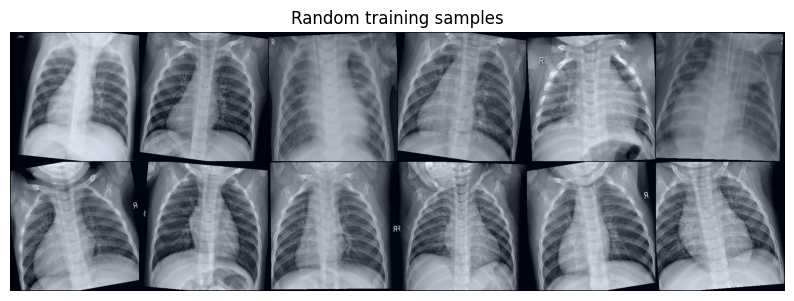

In [2]:
# ------------ Datasets / Loaders ------------
train_ds = datasets.ImageFolder(TRAIN_DIR, transform=train_tfms)
val_ds   = datasets.ImageFolder(VAL_DIR,   transform=eval_tfms)
test_ds  = datasets.ImageFolder(TEST_DIR,  transform=eval_tfms)
class_names = train_ds.classes
print("Classes:", class_names)

# Balanced sampler (training)
targets = np.array(train_ds.targets)
class_counts = np.bincount(targets)
class_weights = 1.0 / (class_counts + 1e-9)
sample_weights = class_weights[targets]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=sampler,
                          num_workers=NUM_WORKERS, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=True)

# ------------ Explore dataset ------------
def show_dataset_overview(ds, title):
    print(f"{title}: {len(ds)} images | classes={ds.classes}")
    cnt = np.bincount(ds.targets)
    for i,c in enumerate(ds.classes):
        print(f"  {c}: {cnt[i]}")

show_dataset_overview(train_ds, "Train")
show_dataset_overview(val_ds,   "Val")
show_dataset_overview(test_ds,  "Test")

def show_samples(ds, n=12):
    idxs = np.random.choice(len(ds), size=min(n, len(ds)), replace=False)
    imgs, labels = zip(*[ds[i] for i in idxs])
    grid = tv_utils.make_grid(torch.stack(imgs), nrow=6, padding=2, normalize=True)
    plt.figure(figsize=(10,5)); plt.imshow(grid.permute(1,2,0)); plt.axis('off'); plt.title('Random training samples'); plt.show()

show_samples(train_ds)


Training Utilities & Evaluation Suite

What it does

AMP GradScaler for mixed precision on GPU.

Loss utilities including label smoothing for from-scratch training (mitigates over-confidence).

run_epoch(...) handles one pass of training/eval with accuracy and probability outputs.

plot_history(...) plots loss and accuracy vs. epoch.

evaluate_full(...) computes:

Metrics: Loss, Accuracy, Precision, Recall, F1, ROC-AUC.

ROC curve plot.

Calibration curve + Brier score.

Pearson/Spearman correlations between labels and predicted probabilities.

What to observe (figures)

Training curves: Healthy training shows train/val loss decreasing; if val loss flattens or rises while train keeps improving, you’re overfitting—early stopping should kick in.

ROC: AUC ideally high (e.g., ≥0.90 for good separation; dataset quality dependent).

Calibration: Reliability curve close to the diagonal; lower Brier is better. Transformers often calibrate reasonably with proper regularization.

Correlations: Higher Pearson/Spearman indicates monotonic, well-ordered probabilities.

In [3]:
# ------------ Training utilities ------------
scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())

def bce_logits_smooth(logits, targets, eps=0.0):
    if eps > 0:
        targets = targets*(1-eps) + 0.5*eps
    return F.binary_cross_entropy_with_logits(logits, targets)

def run_epoch(model, loader, criterion, optimizer=None, grad_clip=None):
    train_mode = optimizer is not None
    model.train(train_mode)
    total_loss = 0.0
    y_true, y_prob = [], []
    if train_mode:
        optimizer.zero_grad(set_to_none=True)
    for images, labels in loader:
        images = images.to(DEVICE, non_blocking=True)
        labels = labels.float().unsqueeze(1).to(DEVICE, non_blocking=True)
        with torch.set_grad_enabled(train_mode):
            with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
                logits = model(images)
                loss = criterion(logits, labels)
            if train_mode:
                scaler.scale(loss).backward()
                if grad_clip: torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
                scaler.step(optimizer); scaler.update()
                optimizer.zero_grad(set_to_none=True)
        total_loss += loss.item() * images.size(0)
        probs = torch.sigmoid(logits).detach().cpu().numpy().ravel()
        y_prob.extend(probs.tolist()); y_true.extend(labels.detach().cpu().numpy().ravel().tolist())
    avg_loss = total_loss/len(loader.dataset)
    y_true = np.array(y_true); y_prob = np.array(y_prob)
    y_pred = (y_prob >= 0.5).astype(int)
    acc = accuracy_score(y_true, y_pred)
    return avg_loss, acc, y_true, y_prob, y_pred

def plot_history(history, title="Training Curves"):
    e = range(1, len(history['train_loss'])+1)
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(e, history['train_loss'], label='Train'); plt.plot(e, history['val_loss'], label='Val')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss'); plt.legend(); plt.grid(True, ls='--', alpha=0.4)
    plt.subplot(1,2,2)
    plt.plot(e, history['train_acc'], label='Train'); plt.plot(e, history['val_acc'], label='Val')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy'); plt.legend(); plt.grid(True, ls='--', alpha=0.4)
    plt.suptitle(title); plt.show()

def evaluate_full(model, loader, title="Model"):
    model.eval()
    y_true, y_prob = [], []
    total_loss = 0.0
    criterion = nn.BCEWithLogitsLoss().to(DEVICE)
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(DEVICE)
            labels = labels.float().unsqueeze(1).to(DEVICE)
            logits = model(images)
            loss = criterion(logits, labels)
            total_loss += loss.item() * images.size(0)
            probs = torch.sigmoid(logits).cpu().numpy().ravel()
            y_prob.extend(probs.tolist()); y_true.extend(labels.cpu().numpy().ravel().tolist())
    y_true = np.array(y_true); y_prob = np.array(y_prob)
    y_pred = (y_prob >= 0.5).astype(int)
    tl = total_loss/len(loader.dataset)
    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec  = recall_score(y_true, y_pred, zero_division=0)
    f1   = f1_score(y_true, y_pred, zero_division=0)
    try: auc = roc_auc_score(y_true, y_prob)
    except: auc = float('nan')

    print(f"\n=== {title} (Test) ===")
    print(f"Loss: {tl:.4f} | Acc: {acc:.4f} | P: {prec:.4f} | R: {rec:.4f} | F1: {f1:.4f} | AUC: {auc:.4f}")
    print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=class_names, digits=4))

    # ROC
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, lw=2, label=f'ROC (AUC={auc:.3f})')
    plt.plot([0,1],[0,1],'--', lw=1)
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title(f'ROC - {title}')
    plt.grid(True, ls='--', alpha=0.4); plt.legend(); plt.show()

    # Calibration
    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=10, strategy='quantile')
    bs = brier_score_loss(y_true, y_prob)
    plt.figure(figsize=(5,4))
    plt.plot(prob_pred, prob_true, marker='o', label='Reliability')
    plt.plot([0,1],[0,1],'--', label='Perfect')
    plt.xlabel('Predicted probability'); plt.ylabel('Observed frequency')
    plt.title(f'Calibration - {title} (Brier={bs:.4f})')
    plt.grid(True, ls='--', alpha=0.4); plt.legend(); plt.show()

    # Correlations
    pr, p_p = pearsonr(y_true, y_prob)
    sr, s_p = spearmanr(y_true, y_prob)
    print(f"Pearson r = {pr:.4f} (p={p_p:.3g}) | Spearman ρ = {sr:.4f} (p={s_p:.3g})")

    return {
        'loss': tl, 'accuracy': acc, 'precision': prec, 'recall': rec,
        'f1': f1, 'auc': auc, 'brier': bs,
        'pearson_r': pr, 'spearman_rho': sr,
        'y_true': y_true, 'y_prob': y_prob, 'y_pred': y_pred
    }


Swin-Tiny Model Definition

What it does

Builds Swin-Tiny and replaces the default head with a custom MLP (1024→256→1) using BatchNorm and Dropout (stronger dropout when training from scratch).

Returns a nn.Sequential(swin, head) on the selected device.

Why it matters

The deeper MLP head increases nonlinearity capacity for a hard, binary medical task.

Dropout/BatchNorm stabilize training and improve calibration/robustness.

In [4]:
# ------------ Swin-Tiny model ------------
def build_swin_tiny(use_pretrained=True):
    if use_pretrained:
        swin = models.swin_t(weights=models.Swin_T_Weights.IMAGENET1K_V1)
    else:
        swin = models.swin_t(weights=None)
    in_feats = swin.head.in_features
    swin.head = nn.Identity()
    head = nn.Sequential(
        nn.Linear(in_feats, 1024),
        nn.ReLU(inplace=True),
        nn.BatchNorm1d(1024),
        nn.Dropout(0.3 if use_pretrained else 0.4),
        nn.Linear(1024, 256),
        nn.ReLU(inplace=True),
        nn.BatchNorm1d(256),
        nn.Dropout(0.25 if use_pretrained else 0.3),
        nn.Linear(256, 1)
    )
    model = nn.Sequential(swin, head)
    return model.to(DEVICE)

def fit_swin(model, epochs, ckpt_path, use_pretrained=True):
    history = {'train_loss':[], 'val_loss':[], 'train_acc':[], 'val_acc':[]}

    if use_pretrained:
        # Warm up: head only
        for p in model[0].parameters(): p.requires_grad = False
        for p in model[1].parameters(): p.requires_grad = True
        optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=LR_HEAD, weight_decay=1e-4)
        criterion = nn.BCEWithLogitsLoss().to(DEVICE)
        warmup_epochs = min(3, max(1, epochs//8))
        best_val, best_w = float('inf'), copy.deepcopy(model.state_dict())
        for ep in range(1, warmup_epochs+1):
            tl, ta, *_ = run_epoch(model, train_loader, criterion, optimizer)
            vl, va, *_ = run_epoch(model, val_loader,   criterion, optimizer=None)
            history['train_loss'].append(tl); history['val_loss'].append(vl)
            history['train_acc'].append(ta);  history['val_acc'].append(va)
            print(f"[Warmup {ep}/{warmup_epochs}] tl {tl:.4f} ta {ta:.3f} | vl {vl:.4f} va {va:.3f}")
            if vl < best_val: best_val, best_w = vl, copy.deepcopy(model.state_dict()); torch.save(best_w, ckpt_path)

        # Unfreeze and fine-tune
        for p in model.parameters(): p.requires_grad = True
        optimizer = optim.AdamW(model.parameters(), lr=LR_ALL_SWINT, weight_decay=WEIGHT_DECAY_SWINT)
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max(1, epochs-warmup_epochs), eta_min=1e-6)
        best_val, best_w, wait = float('inf'), copy.deepcopy(model.state_dict()), 0

        for ep in range(warmup_epochs+1, epochs+1):
            tl, ta, *_ = run_epoch(model, train_loader, criterion, optimizer)
            vl, va, *_ = run_epoch(model, val_loader,   criterion, optimizer=None)
            scheduler.step()
            history['train_loss'].append(tl); history['val_loss'].append(vl)
            history['train_acc'].append(ta);  history['val_acc'].append(va)
            print(f"[{ep}/{epochs}] tl {tl:.4f} ta {ta:.3f} | vl {vl:.4f} va {va:.3f}")
            if vl < best_val:
                best_val, wait = vl, 0
                best_w = copy.deepcopy(model.state_dict()); torch.save(best_w, ckpt_path)
            else:
                wait += 1
                if wait >= PATIENCE:
                    print(f"Early stopping at epoch {ep}. Best val loss {best_val:.4f}")
                    break
    else:
        # Train from scratch
        optimizer = optim.AdamW(model.parameters(), lr=LR_ALL_SWINT, weight_decay=WEIGHT_DECAY_SWINT)
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-6)
        best_val, best_w, wait = float('inf'), copy.deepcopy(model.state_dict()), 0

        for ep in range(1, epochs+1):
            tl, ta, *_ = run_epoch(model, train_loader, lambda lg,y: bce_logits_smooth(lg,y,LABEL_SMOOTH), optimizer, grad_clip=1.0)
            vl, va, *_ = run_epoch(model, val_loader,   nn.BCEWithLogitsLoss().to(DEVICE), optimizer=None)
            scheduler.step()
            history['train_loss'].append(tl); history['val_loss'].append(vl)
            history['train_acc'].append(ta);  history['val_acc'].append(va)
            print(f"[{ep}/{epochs}] tl {tl:.4f} ta {ta:.3f} | vl {vl:.4f} va {va:.3f}")
            if vl < best_val:
                best_val, wait = vl, 0
                best_w = copy.deepcopy(model.state_dict()); torch.save(best_w, ckpt_path)
            else:
                wait += 1
                if wait >= PATIENCE:
                    print(f"Early stopping at epoch {ep}. Best val loss {best_val:.4f}")
                    break

    model.load_state_dict(best_w)
    return model, history


Train Swin-Tiny

What it does

Creates the model and a checkpoint path.

If pretrained: warms up the head, then unfreezes and fine-tunes with CosineAnnealingLR and early stopping.

From scratch (your current setting): trains end-to-end with label smoothing, cosine schedule, weight decay, and early stopping.

Saves best weights by val loss and returns training history.

Plots Swin-Tiny training curves.

What to observe (figure)

From scratch: early epochs may be noisy; after a few epochs, expect steady improvement.

Look for divergence between train/val curves (overfit) vs. parallel descent (healthy).

Early stopping message indicates the best checkpoint was captured before overfitting.

[1/80] tl 0.5836 ta 0.708 | vl 1.2484 va 0.625
[2/80] tl 0.4672 ta 0.814 | vl 1.2106 va 0.562
[3/80] tl 0.4267 ta 0.830 | vl 1.2088 va 0.625
[4/80] tl 0.3792 ta 0.865 | vl 1.4184 va 0.500
[5/80] tl 0.3533 ta 0.883 | vl 1.6824 va 0.500
[6/80] tl 0.3295 ta 0.892 | vl 0.8500 va 0.625
[7/80] tl 0.3230 ta 0.897 | vl 1.1809 va 0.562
[8/80] tl 0.3257 ta 0.898 | vl 1.6615 va 0.562
[9/80] tl 0.3075 ta 0.902 | vl 1.0878 va 0.562
[10/80] tl 0.3144 ta 0.907 | vl 1.2721 va 0.562
[11/80] tl 0.3109 ta 0.900 | vl 1.0118 va 0.625
[12/80] tl 0.2942 ta 0.913 | vl 1.5255 va 0.500
Early stopping at epoch 12. Best val loss 0.8500


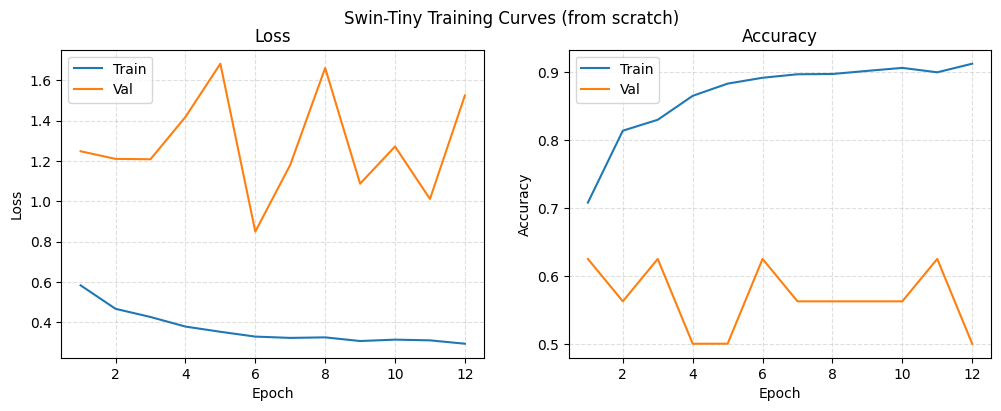

In [5]:
# ------------ Train Swin-Tiny ------------
swin = build_swin_tiny(USE_PRETRAINED_SWINT)
swin_ckpt = os.path.join(OUT_DIR, f"swin_tiny_{'ft' if USE_PRETRAINED_SWINT else 'scratch'}_best.pth")
swin, swin_hist = fit_swin(swin, EPOCHS_SWINT, swin_ckpt, use_pretrained=USE_PRETRAINED_SWINT)
plot_history(swin_hist, f"Swin-Tiny Training Curves ({'fine-tune' if USE_PRETRAINED_SWINT else 'from scratch'})")


Optional ViT-B/16 Fine-tune (RUN_VIT=True)

What it does

Loads pretrained ViT-B/16 (SWAG) weights.

Replaces the head with a larger MLP (2048→512→1) with BatchNorm/Dropout.

Warm-up head (ViT frozen), then unfreeze everything and fine-tune with cosine schedule.

Saves best ViT ckpt and plots ViT training curves.

What to observe (figure)

ViT fine-tuning typically converges faster than from-scratch Swin (thanks to pretraining).

Val loss should improve within a few epochs; curves often look smoother than from-scratch runs.

Downloading: "https://download.pytorch.org/models/vit_b_16_swag-9ac1b537.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16_swag-9ac1b537.pth


100%|██████████| 331M/331M [00:04<00:00, 77.5MB/s]


[ViT Warmup 1/3] tl 0.1716 ta 0.934 | vl 0.4866 va 0.875
[ViT Warmup 2/3] tl 0.1297 ta 0.954 | vl 1.0096 va 0.625
[ViT Warmup 3/3] tl 0.1226 ta 0.956 | vl 1.0082 va 0.562
[ViT 4/20] tl 0.1295 ta 0.951 | vl 1.4193 va 0.562
[ViT 5/20] tl 0.0856 ta 0.968 | vl 1.6505 va 0.625
[ViT 6/20] tl 0.0786 ta 0.972 | vl 0.8098 va 0.750
[ViT 7/20] tl 0.0721 ta 0.974 | vl 0.5409 va 0.688
[ViT 8/20] tl 0.0658 ta 0.977 | vl 1.0566 va 0.562
[ViT 9/20] tl 0.0584 ta 0.978 | vl 2.0394 va 0.500
[ViT 10/20] tl 0.0450 ta 0.984 | vl 0.6204 va 0.625
[ViT 11/20] tl 0.0474 ta 0.983 | vl 0.3862 va 0.875
[ViT 12/20] tl 0.0468 ta 0.985 | vl 0.2015 va 0.875
[ViT 13/20] tl 0.0314 ta 0.990 | vl 1.3566 va 0.625
[ViT 14/20] tl 0.0340 ta 0.988 | vl 0.9353 va 0.750
[ViT 15/20] tl 0.0214 ta 0.993 | vl 1.2532 va 0.625
[ViT 16/20] tl 0.0331 ta 0.987 | vl 1.4643 va 0.625
[ViT 17/20] tl 0.0237 ta 0.993 | vl 1.0356 va 0.688
[ViT 18/20] tl 0.0191 ta 0.994 | vl 0.8415 va 0.688
[ViT 19/20] tl 0.0127 ta 0.997 | vl 1.1261 va 0.688
[Vi

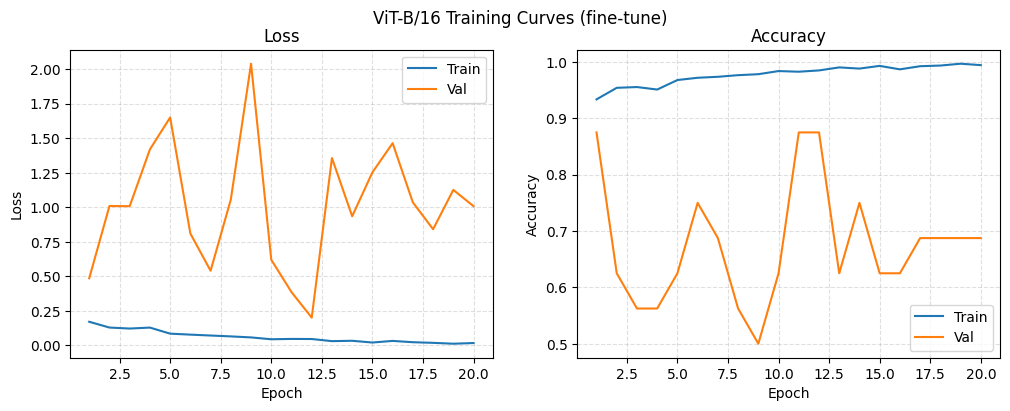

In [6]:
# ------------ Optional: ViT-B/16 fine-tune for comparison ------------
if RUN_VIT:
    vit = models.vit_b_16(weights=models.ViT_B_16_Weights.IMAGENET1K_SWAG_E2E_V1)
    vit.heads = nn.Identity()
    vit_head = nn.Sequential(
        nn.Linear(vit.hidden_dim, 2048), nn.ReLU(inplace=True), nn.BatchNorm1d(2048), nn.Dropout(0.3),
        nn.Linear(2048, 512), nn.ReLU(inplace=True), nn.BatchNorm1d(512), nn.Dropout(0.3),
        nn.Linear(512, 1)
    )
    vit = nn.Sequential(vit, vit_head).to(DEVICE)

    # warmup head
    for p in vit[0].parameters(): p.requires_grad = False
    for p in vit[1].parameters(): p.requires_grad = True
    optimizer = optim.AdamW(filter(lambda p: p.requires_grad, vit.parameters()), lr=LR_HEAD, weight_decay=1e-4)
    vit_hist = {'train_loss':[], 'val_loss':[], 'train_acc':[], 'val_acc':[]}
    best_val, best_w = float('inf'), copy.deepcopy(vit.state_dict())
    crit = nn.BCEWithLogitsLoss().to(DEVICE)
    warm = 3
    for ep in range(1, warm+1):
        tl, ta, *_ = run_epoch(vit, train_loader, crit, optimizer)
        vl, va, *_ = run_epoch(vit, val_loader,   crit, optimizer=None)
        vit_hist['train_loss'].append(tl); vit_hist['val_loss'].append(vl)
        vit_hist['train_acc'].append(ta);  vit_hist['val_acc'].append(va)
        print(f"[ViT Warmup {ep}/{warm}] tl {tl:.4f} ta {ta:.3f} | vl {vl:.4f} va {va:.3f}")
        if vl < best_val: best_val, best_w = vl, copy.deepcopy(vit.state_dict())

    # unfreeze all
    for p in vit.parameters(): p.requires_grad = True
    optimizer = optim.AdamW(vit.parameters(), lr=LR_ALL_VIT, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS_VIT-warm, eta_min=1e-6)
    for ep in range(warm+1, EPOCHS_VIT+1):
        tl, ta, *_ = run_epoch(vit, train_loader, crit, optimizer)
        vl, va, *_ = run_epoch(vit, val_loader,   crit, optimizer=None)
        scheduler.step()
        vit_hist['train_loss'].append(tl); vit_hist['val_loss'].append(vl)
        vit_hist['train_acc'].append(ta);  vit_hist['val_acc'].append(va)
        print(f"[ViT {ep}/{EPOCHS_VIT}] tl {tl:.4f} ta {ta:.3f} | vl {vl:.4f} va {va:.3f}")
        if vl < best_val: best_val, best_w = vl, copy.deepcopy(vit.state_dict())
    vit.load_state_dict(best_w)
    vit_ckpt = os.path.join(OUT_DIR, "vit_b16_ft_best.pth"); torch.save(vit.state_dict(), vit_ckpt)
    plot_history(vit_hist, "ViT-B/16 Training Curves (fine-tune)")


Test-time Evaluation

What it does

Runs the full evaluation (Cell 3) on the test set for:

Swin-Tiny (either FT or scratch, matching your toggle).

ViT-B/16 (if enabled).

Prints metric tables and renders ROC and calibration plots for each.

What to observe (figures & metrics)

Compare AUC/F1/Recall (recall is crucial in medical screening; consider threshold tuning for sensitivity).

Calibration: If curves are above/below diagonal, consider temperature scaling or focal loss in future runs.

Brier score: Lower is better; compare Swin vs. ViT.


=== Swin-Tiny (Scratch) (Test) ===
Loss: 0.4702 | Acc: 0.8109 | P: 0.8009 | R: 0.9282 | F1: 0.8599 | AUC: 0.8919

Classification Report:
               precision    recall  f1-score   support

      NORMAL     0.8372    0.6154    0.7094       234
   PNEUMONIA     0.8009    0.9282    0.8599       390

    accuracy                         0.8109       624
   macro avg     0.8190    0.7718    0.7846       624
weighted avg     0.8145    0.8109    0.8034       624



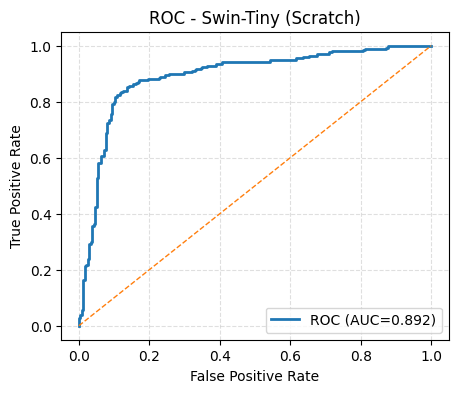

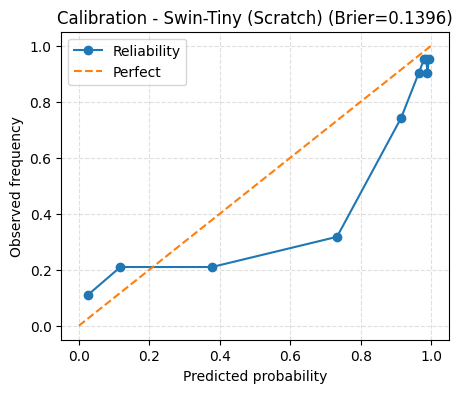

Pearson r = 0.6659 (p=3.42e-81) | Spearman ρ = 0.6572 (p=2.06e-78)

=== ViT-B/16 (Fine-tune) (Test) ===
Loss: 0.4944 | Acc: 0.8590 | P: 0.8159 | R: 1.0000 | F1: 0.8986 | AUC: 0.9680

Classification Report:
               precision    recall  f1-score   support

      NORMAL     1.0000    0.6239    0.7684       234
   PNEUMONIA     0.8159    1.0000    0.8986       390

    accuracy                         0.8590       624
   macro avg     0.9079    0.8120    0.8335       624
weighted avg     0.8849    0.8590    0.8498       624



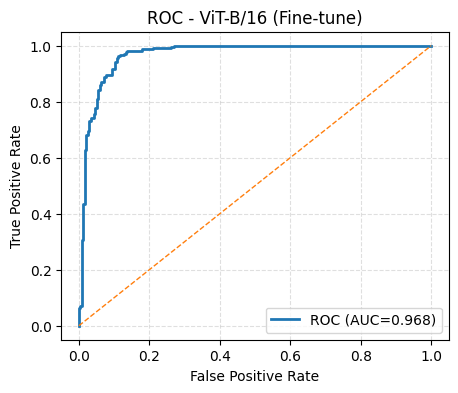

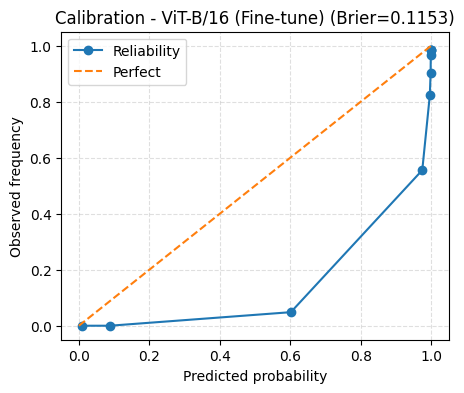

Pearson r = 0.7707 (p=7.1e-124) | Spearman ρ = 0.7849 (p=2.05e-131)


In [7]:
# ------------ Test evaluation ------------
swin_test = evaluate_full(swin, test_loader, title=f"Swin-Tiny ({'FT' if USE_PRETRAINED_SWINT else 'Scratch'})")
vit_test = None
if RUN_VIT:
    vit_test = evaluate_full(vit, test_loader, title="ViT-B/16 (Fine-tune)")


Interpretability Gallery (Attention Rollout / Activation Overlays)

What it does

Provides attention_rollout_vitlike(...):

For ViT, computes an approximate attention rollout across layers to yield a spatial saliency mask.

For Swin, uses a feature-norm heatmap (since official attn maps aren’t exposed) as a pragmatic proxy.

show_gallery(...) randomly picks examples per TP/FP/TN/FN and overlays heatmaps on images.

What to observe (figures)

TP overlays: Hot regions should align with pneumonia patterns (e.g., lobar consolidations, interstitial markings).

FP overlays: Check if model fixates on non-pathological structures (ribs, devices) → suggests dataset artifacts or bias.

FN overlays: Cases where subtle opacities weren’t highlighted—useful for error analysis and data curation.

TN overlays: Expect low, diffuse activation.

In [ ]:
# ------------ Interpretability: Transformer Attention Rollout ------------
def attention_rollout_vitlike(model, images, size=IMG_SIZE, discard_ratio=0.9):
    """
    Generic attention rollout for torchvision ViT or Swin:
    - For ViT: model[0] is ViT encoder
    - For Swin: approximate via last feature activation magnitude (fallback)
    """
    model.eval()
    net = model[0] if isinstance(model, nn.Sequential) else model
    with torch.no_grad():
        x = images.to(DEVICE)
        if isinstance(net, models.VisionTransformer):
            # --- ViT path ---
            x_p = net._process_input(x)
            x_p = net.conv_proj(x_p).flatten(2).transpose(1,2)
            cls = net.class_token.expand(x_p.size(0), -1, -1)
            x_p = torch.cat((cls, x_p), dim=1) + net.encoder.pos_embedding
            x_p = net.encoder.dropout(x_p)
            mats=[]
            for blk in net.encoder.layers:
                attn_out, attn_weights = blk.attn(x_p, need_weights=True)   # (B,heads,N,N)
                mats.append(attn_weights.mean(dim=1))
                x_p = blk.ln_1(x_p + attn_out)
                x_p = blk.ln_2(x_p + blk.mlp(x_p))
            b = mats[0].size(0); N = mats[0].size(-1)
            joint = torch.eye(N, device=DEVICE).unsqueeze(0).repeat(b,1,1)
            for a in mats:
                flat = a.view(b,-1)
                k = (flat.size(1)*discard_ratio).round().long()
                _, idx = torch.topk(flat, k.item(), dim=1, largest=False)
                flat.scatter_(1, idx, 0); a = flat.view_as(a)
                a = a/(a.sum(dim=-1, keepdim=True)+1e-6)
                joint = a @ joint
            mask = joint[:,0,1:]
            hw = int(math.sqrt(mask.size(-1))); mask = mask.view(b,1,hw,hw)
            mask = F.interpolate(mask, size=(size,size), mode='bilinear', align_corners=False)
            mask = (mask - mask.min())/(mask.max()-mask.min()+1e-6)
            return mask.cpu()
        else:
            # --- Swin path fallback: activation magnitude
            feats = net.features(x)  # (B,C,h,w)
            heat = feats.norm(dim=1, keepdim=True)
            heat = F.interpolate(heat, size=(size,size), mode='bilinear', align_corners=False)
            heat = (heat - heat.min())/(heat.max()-heat.min()+1e-6)
            return heat.cpu()

def show_gallery(model, ds, y_true, y_pred, title="Interpretability Gallery"):
    idx_tp = np.where((y_true==1) & (y_pred==1))[0]
    idx_fp = np.where((y_true==0) & (y_pred==1))[0]
    idx_tn = np.where((y_true==0) & (y_pred==0))[0]
    idx_fn = np.where((y_true==1) & (y_pred==0))[0]
    groups = [("TP", idx_tp), ("FP", idx_fp), ("TN", idx_tn), ("FN", idx_fn)]
    for name, idxs in groups:
        if len(idxs)==0:
            print(f"No {name} examples.")
            continue
        pick = np.random.choice(idxs, size=min(4, len(idxs)), replace=False)
        plt.figure(figsize=(10,5))
        for j,k in enumerate(pick):
            img, _ = ds[k]
            vis = (img - img.min())/(img.max()-img.min()+1e-6)
            with torch.no_grad():
                mask = attention_rollout_vitlike(model, img.unsqueeze(0))
            overlay = 0.6*vis + 0.4*mask[0].repeat(3,1,1)
            plt.subplot(1,4,j+1); plt.imshow(overlay.permute(1,2,0)); plt.axis('off')
        plt.suptitle(f'{title}: {name} (Transformer attention/activation overlays)')
        plt.show()

show_gallery(swin, test_ds, swin_test['y_true'], swin_test['y_pred'], title='Swin-Tiny')
if RUN_VIT and vit_test is not None:
    show_gallery(vit, test_ds, vit_test['y_true'], vit_test['y_pred'], title='ViT-B/16')


Artifact Export

What it does

Saves training histories (CSV), test metrics (CSV), and best weights (.pth) for Swin and (if present) ViT.

Outputs live under OUT_DIR (default /content) for later reporting or reuse.

Why it matters

Having CSVs enables reproducible plots in reports and quick comparisons across runs.

Saving the best checkpoints lets you deploy or re-evaluate without retraining.

In [ ]:
# ------------ Save artifacts & summaries to disk ------------
def save_history_csv(history, path_csv): pd.DataFrame(history).to_csv(path_csv, index=False)
def save_metrics_csv(metrics_dict, path_csv):
    md = {k:v for k,v in metrics_dict.items() if not isinstance(v, np.ndarray)}
    pd.DataFrame([md]).to_csv(path_csv, index=False)

swin_hist_csv = os.path.join(OUT_DIR, f"swin_tiny_{'ft' if USE_PRETRAINED_SWINT else 'scratch'}_history.csv")
swin_metrics_csv = os.path.join(OUT_DIR, f"swin_tiny_{'ft' if USE_PRETRAINED_SWINT else 'scratch'}_test_metrics.csv")
save_history_csv(swin_hist, swin_hist_csv); save_metrics_csv(swin_test, swin_metrics_csv)
torch.save(swin.state_dict(), os.path.join(OUT_DIR, f"swin_tiny_{'ft' if USE_PRETRAINED_SWINT else 'scratch'}_best.pth"))

if RUN_VIT and vit_test is not None:
    vit_hist_csv = os.path.join(OUT_DIR, "vit_b16_ft_history.csv")
    vit_metrics_csv = os.path.join(OUT_DIR, "vit_b16_ft_test_metrics.csv")
    save_history_csv(vit_hist, vit_hist_csv); save_metrics_csv(vit_test, vit_metrics_csv)


Typical Observations & How to Read Your Plots

Swin-Tiny (from scratch) vs ViT-B/16 (fine-tune):

ViT often reaches strong validation performance quickly via transfer learning.

Swin-Tiny can match or approach ViT with enough epochs and regularization, and sometimes yields cleaner calibration due to its hierarchical bias and windowed attention.

ROC-AUC: AUC ≥0.90 indicates good separability on this dataset; absolute values depend heavily on data quality and leakage controls.

Calibration Plot: A curve near the diagonal with low Brier suggests trustworthy probabilities—important for threshold selection and downstream clinical workflows.

Attention/Activation Overlays: Useful to verify that the model focuses on pulmonary fields rather than confounders (text markers, devices, borders). Systematic FP patterns point to data curation opportunities.


SWIN-TINY (FROM-SCRATCH) PNEUMONIA DETECTION - PROJECT SUMMARY
DATASET STATISTICS:
   Training samples: 5216
   Validation samples: 16
   Test samples: 624
   Classes: ['NORMAL', 'PNEUMONIA']

MODEL ARCHITECTURE:
   Model: Swin-Tiny (From-scratch)
   Input Size: 384x384x3
   Trainable Parameters: 28,572,027
   Total Parameters: 28,572,027
   Key Feature: Windowed self-attention (data-efficient); transformer overlays for interpretability

TRAINING PERFORMANCE:
   Final Train Accuracy: 0.9128
   Final Val   Accuracy: 0.5000

TEST PERFORMANCE:
   Test Accuracy:  0.8109
   Test Precision: 0.8009
   Test Recall:    0.9282
   Test F1-Score:  0.8599
   Test AUC:       0.8919
   Brier Score:    0.1396
   Pearson r:      0.6659 | Spearman ρ: 0.6572

VIT-B/16 (FINE-TUNE) PNEUMONIA DETECTION - PROJECT SUMMARY
DATASET STATISTICS:
   Training samples: 5216
   Validation samples: 16
   Test samples: 624
   Classes: ['NORMAL', 'PNEUMONIA']

MODEL ARCHITECTURE:
   Model: ViT-B/16 (Fine-tune)
   Input

,Model,Accuracy,Precision,Recall,F1,AUC,Brier↓
0,Swin-Tiny Scratch,0.8109,0.8009,0.9282,0.8599,0.8919,0.1396
1,ViT-B/16 FT,0.8590,0.8159,1.0000,0.8986,0.9680,0.1153



Comparison (raw):
                Model  Accuracy  Precision    Recall        F1       AUC  \
0  Swin-Tiny Scratch  0.810897   0.800885  0.928205  0.859857  0.891869   
1        ViT-B/16 FT  0.858974   0.815900  1.000000  0.898618  0.968025   

     Brier↓  
0  0.139613  
1  0.115298  


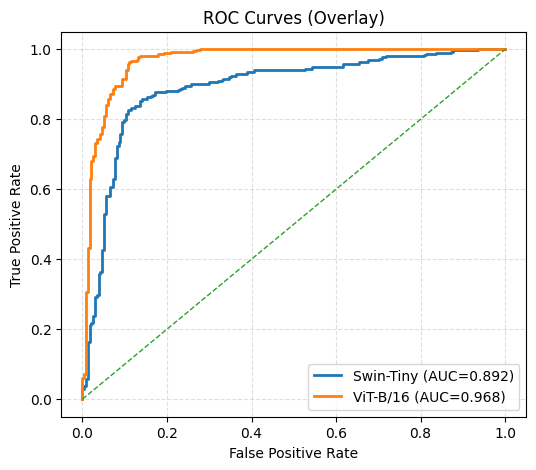

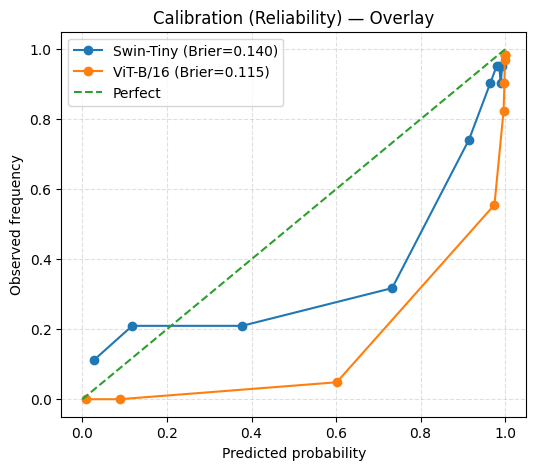

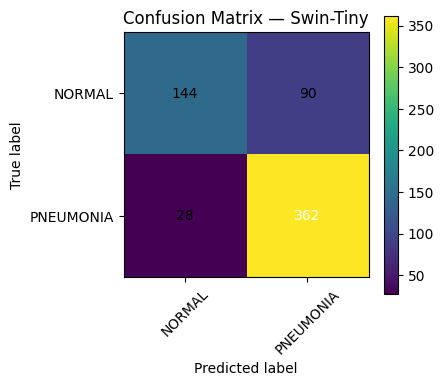

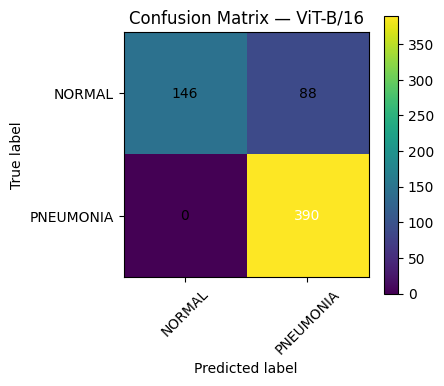

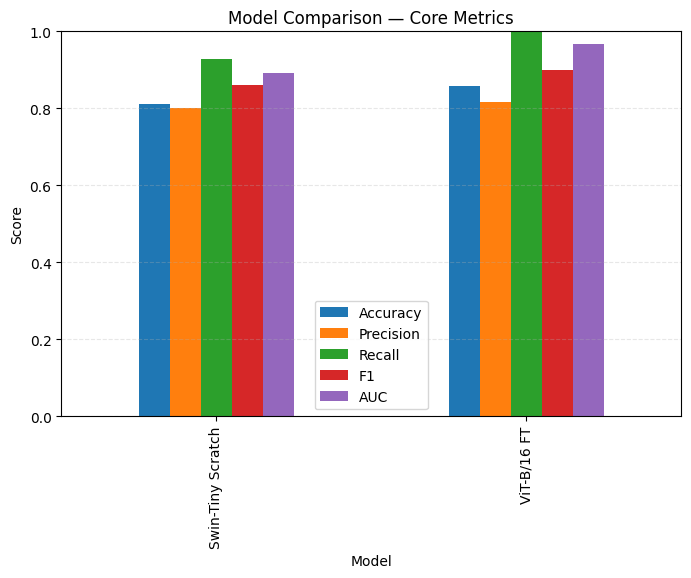

In [9]:
# ------------ Human-readable summaries ------------
def count_params(tm):
    total = sum(p.numel() for p in tm.parameters())
    trainable = sum(p.numel() for p in tm.parameters() if p.requires_grad)
    return trainable, total

def print_summary(model_name, model_obj, history, metrics_dict, ds_sizes, img_size, notes):
    train_len, val_len, test_len = ds_sizes
    print(f"\n{model_name.upper()} PNEUMONIA DETECTION - PROJECT SUMMARY")
    print("="*70)
    print("DATASET STATISTICS:")
    print(f"   Training samples: {train_len}")
    print(f"   Validation samples: {val_len}")
    print(f"   Test samples: {test_len}")
    print(f"   Classes: {class_names}")
    print("\nMODEL ARCHITECTURE:")
    trainable_params, total_params = count_params(model_obj)
    print(f"   Model: {model_name}")
    print(f"   Input Size: {img_size}x{img_size}x3")
    print(f"   Trainable Parameters: {trainable_params:,}")
    print(f"   Total Parameters: {total_params:,}")
    print(f"   Key Feature: {notes}")
    print("\nTRAINING PERFORMANCE:")
    print(f"   Final Train Accuracy: {history['train_acc'][-1]:.4f}")
    print(f"   Final Val   Accuracy: {history['val_acc'][-1]:.4f}")
    print("\nTEST PERFORMANCE:")
    print(f"   Test Accuracy:  {metrics_dict['accuracy']:.4f}")
    print(f"   Test Precision: {metrics_dict['precision']:.4f}")
    print(f"   Test Recall:    {metrics_dict['recall']:.4f}")
    print(f"   Test F1-Score:  {metrics_dict['f1']:.4f}")
    print(f"   Test AUC:       {metrics_dict['auc']:.4f}")
    print(f"   Brier Score:    {metrics_dict['brier']:.4f}")
    print(f"   Pearson r:      {metrics_dict['pearson_r']:.4f} | Spearman ρ: {metrics_dict['spearman_rho']:.4f}")

print_summary(
    f"Swin-Tiny ({'Fine-tune' if USE_PRETRAINED_SWINT else 'From-scratch'})",
    swin, swin_hist, swin_test, (len(train_ds), len(val_ds), len(test_ds)), IMG_SIZE,
    "Windowed self-attention (data-efficient); transformer overlays for interpretability"
)

if RUN_VIT and vit_test is not None:
    print_summary(
        "ViT-B/16 (Fine-tune)",
        vit, vit_hist, vit_test, (len(train_ds), len(val_ds), len(test_ds)), IMG_SIZE,
        "Global self-attention; transformer overlays for interpretability"
    )

# ------------ Unified comparison table ------------
rows = [{
    "Model": "Swin-Tiny" + (" FT" if USE_PRETRAINED_SWINT else " Scratch"),
    "Accuracy": swin_test['accuracy'], "Precision": swin_test['precision'],
    "Recall": swin_test['recall'], "F1": swin_test['f1'], "AUC": swin_test['auc'],
    "Brier↓": swin_test['brier']
}]
if RUN_VIT and vit_test is not None:
    rows.append({
        "Model": "ViT-B/16 FT",
        "Accuracy": vit_test['accuracy'], "Precision": vit_test['precision'],
        "Recall": vit_test['recall'], "F1": vit_test['f1'], "AUC": vit_test['auc'],
        "Brier↓": vit_test['brier']
    })

comp_df = pd.DataFrame(rows)
display(comp_df.style.format({k:"{:.4f}" for k in comp_df.columns if k!="Model"})
        .set_properties(subset=pd.IndexSlice[:, comp_df.columns[1:]], **{'text-align': 'right'})
        .set_table_styles([{'selector':'th','props':[('text-align','left')]}]))
print("\nComparison (raw):\n", comp_df)

# ------------ Side-by-side ROC & Calibration (overlay) ------------
def plot_overlay_roc(swin_test, vit_test=None):
    plt.figure(figsize=(6,5))
    fpr, tpr, _ = roc_curve(swin_test['y_true'], swin_test['y_prob'])
    plt.plot(fpr, tpr, label=f"Swin-Tiny (AUC={swin_test['auc']:.3f})", lw=2)
    if vit_test is not None:
        fpr_v, tpr_v, _ = roc_curve(vit_test['y_true'], vit_test['y_prob'])
        plt.plot(fpr_v, tpr_v, label=f"ViT-B/16 (AUC={vit_test['auc']:.3f})", lw=2)
    plt.plot([0,1],[0,1],'--', lw=1)
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curves (Overlay)')
    plt.grid(True, ls='--', alpha=0.4); plt.legend(); plt.show()

def plot_overlay_calibration(swin_test, vit_test=None, n_bins=10):
    plt.figure(figsize=(6,5))
    pt, pp = calibration_curve(swin_test['y_true'], swin_test['y_prob'], n_bins=n_bins, strategy='quantile')
    plt.plot(pp, pt, marker='o', label=f"Swin-Tiny (Brier={swin_test['brier']:.3f})")
    if vit_test is not None:
        pt2, pp2 = calibration_curve(vit_test['y_true'], vit_test['y_prob'], n_bins=n_bins, strategy='quantile')
        plt.plot(pp2, pt2, marker='o', label=f"ViT-B/16 (Brier={vit_test['brier']:.3f})")
    plt.plot([0,1],[0,1],'--', label='Perfect')
    plt.xlabel('Predicted probability'); plt.ylabel('Observed frequency')
    plt.title('Calibration (Reliability) — Overlay')
    plt.grid(True, ls='--', alpha=0.4); plt.legend(); plt.show()

plot_overlay_roc(swin_test, vit_test if (RUN_VIT and vit_test is not None) else None)
plot_overlay_calibration(swin_test, vit_test if (RUN_VIT and vit_test is not None) else None)

# ------------ Confusion matrices ------------
def plot_confusion(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4.5,4))
    plt.imshow(cm, interpolation='nearest')
    plt.title(title); plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45); plt.yticks(tick_marks, class_names)
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label'); plt.xlabel('Predicted label')
    plt.tight_layout(); plt.show()

plot_confusion(swin_test['y_true'], swin_test['y_pred'], "Confusion Matrix — Swin-Tiny")
if RUN_VIT and vit_test is not None:
    plot_confusion(vit_test['y_true'], vit_test['y_pred'], "Confusion Matrix — ViT-B/16")

# ------------ Metric bar chart (side-by-side) ------------
def plot_metric_bars(comp_df):
    metrics = ["Accuracy","Precision","Recall","F1","AUC"]
    df = comp_df.set_index("Model")[metrics]
    ax = df.plot(kind='bar', figsize=(8,5))
    plt.title("Model Comparison — Core Metrics")
    plt.ylabel("Score"); plt.ylim(0,1)
    plt.grid(True, axis='y', ls='--', alpha=0.3)
    plt.show()

plot_metric_bars(comp_df)
